# PRÁTICA GUIADA: Otimização de modelos I

## Introdução

#### Nos projetos de [`machine learning`](https://www.kdnuggets.com/2020/05/hyperparameter-optimization-machine-learning-models.html) é comum compararmos diversos modelos e selecionar aquele cuja performance se destaca dos demais. Uma das coisas que podemos fazer para melhorar a performance dos algoritmos é encontrar a melhor arquitetura para estes. Quando falamos em arquitetura, estamos falando de parâmetros que definimos previamente, ou seja, é algo definido antes do treinamento do modelo. Dessa forma, existem diversas técnicas que nos ajudam a buscar qual melhor conjunto de parâmetros que mais favorece o aprendizados dos algoritmos.

#### Alguns desses métodos são:

- [`Grid Search`](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e) 
- [`Randomized Search`](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)
- [`Bayesian Search`](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
- [`Algoritmos Genéticos`](https://heartbeat.fritz.ai/hyperparameter-optimization-with-genetic-algorithms-in-kotlin-75e9c5a1e5ab)

#### Esses métodos se diferenciam em velocidade e também em forma. Nas nossas aulas, abordaremos os 2 primeiros e explanaremos um pouco sobre o terceiro.

# Grid Search CV

## O que é Grid Search CV

#### É sabido que não conhecemos qual a melhor arquitetura para nossos modelos de maneira prévia. Assim sendo, uma abordagem que podemos ter para resolver o problema da arquitetura é testar exaustivamente até encontrar o melhor conjunto. O [`Grid Search CV`]() faz isso. Na prática, ele é um algoritmo que está dentro do [`sklearn`](https://scikit-learn.org/stable/modules/grid_search.html) e podemos utilizá-lo junto da [`validação cruzada`](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d), que vimos nas aulas anteriores, para encontrar esse melhor conjunto, de forma automatizada.

## Como o Grid Search Funciona?

#### Como o próprio nome já diz, [`Grid Search`](https://elutins.medium.com/grid-searching-in-machine-learning-quick-explanation-and-python-implementation-550552200596#:~:text=Grid%2Dsearching%20is%20the%20process,parameters%20for%20a%20given%20model.&text=Grid%2DSearch%20will%20build%20a,a%20model%20for%20each%20combination.) se trata de uma busca em grade. A grade é o conjunto dos possíveis valores que os hiperparâmetros podem assumir. Quando temos apenas $2$ hiperparâmetros, conseguimos visualizar a grade desas forma.

<img src="gridsearchCV.png" width=500>

#### Para preparar nosso espaço de busca, criamos dicionários.

``` python
HyperParamDict = {'C': [0.1, 1, 10, 100, 1000],  
   'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf',’linear’,'sigmoid']
 }
```

#### Aqui, queremos testar valores de $C$, $gamma$ e também o tipo de $kernel$ a ser usado em uma [`SVM`](https://www.kdnuggets.com/2020/03/machine-learning-algorithm-svm-explained.html). Uma observação importante é que apenas os hiperparâmetros definidos no dicionário serão variados. Os demais serão definidos como padrão (`default`).

#### Na prática, o [`grid search`](https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a) vai rodar uma [`validação cruzada`](https://www.javatpoint.com/cross-validation-in-machine-learning) para cada possível combinação de valores desse dicionário. A ideia é trazer o conjunto que produz o menor erro de validação/melhor performance de validação.

#### Após a otimização dos hiperparâmetros, podemos estimar o erro em uma base de teste, ainda não vista.

# Prática Guiada: Demonstração de `GridSearchCV`

#### Vamos usar o conjunto de dados [`Iris`](https://digital.library.adelaide.edu.au/dspace/handle/2440/15227). Veremos como usar [`GridSearchCV`](https://towardsdatascience.com/tagged/gridsearchcv) para otimizar o hiperparâmetro `k` do algoritmo de vizinhos mais próximos.

In [60]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

In [61]:
# separando x e y
df = load_iris()
X = df.data
y = df.target

In [62]:
# Split de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state = 123
                                                   )

len(X_train), len(X_test), len(y_train), len(y_test)

(120, 30, 120, 30)

## 1. Escrevendo os parâmetros à mão

#### É claro que, dependendo do modelo, os hiperparâmetros podem ter um efeito considerável na qualidade da previsão. 

#### O método [`stratified kfold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) é uma variação de `KFold`, que retorna dobras estratificadas. As dobras são feitas preservando-se o percentual de amostras de cada classe.

In [63]:
skf = StratifiedKFold(n_splits = 10, 
                      shuffle = True, 
                      random_state = 123
                     )

In [64]:
k_range = list(range(1, 100))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, 
                             X_train, 
                             y_train, 
                             cv = skf, 
                             scoring = 'accuracy'
                            )
    k_scores.append(scores.mean())

In [65]:
import numpy as np
np.amax(k_scores)

0.9833333333333332

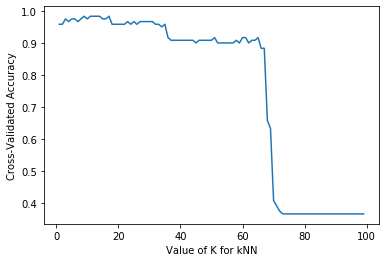

In [66]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for kNN')
plt.ylabel('Cross-Validated Accuracy');

In [67]:
k_range[np.argmax(k_scores)]

9

#### Como sempre, observamos que o desempenho muda para diferentes valores do hiperparâmetro. Podemos sistematizar essa pesquisa e adicionar mais hiperparâmetros à exploração. 

## 2. Usando `GridSearch`

In [68]:
from sklearn.model_selection import GridSearchCV

#### É definida uma lista de parâmetros a serem testados.

In [69]:
k_range = list(range(1, 31))
knn = KNeighborsClassifier(n_neighbors = 8)

In [70]:
param_grid = dict(n_neighbors = range(1,31))
print(param_grid)

{'n_neighbors': range(1, 31)}


#### Vamos Instanciar o método [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para uma pesquisa exaustiva sobre valores de parâmetros especificados para um estimador.  Note que o `CV` no final do nome é de [`Cross Validation`](https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/), esse módulo já realiza a validação cruzada dos dados.

In [71]:
grid = GridSearchCV(knn, 
                    param_grid, 
                    cv = skf, 
                    scoring = 'accuracy'
                   )

Fazer o ajuste

In [72]:
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=KNeighborsClassifier(n_neighbors=8),
             param_grid={'n_neighbors': range(1, 31)}, scoring='accuracy')

#### O [`GridSeachCV`](https://stackabuse.com/grid-search-optimization-algorithm-in-python/) retorna um dicionário com muitas informações. Do momento da configuração de cada parâmetro até os `scores` médios, via validação cruzada. Ele também fornece os `scores` em cada conjunto de treino e teste da Validação Cruzada `K-Fold`. 

In [73]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [74]:
pd.DataFrame(grid.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

Vamos ver o melhor modelo:

In [75]:
grid.best_params_

{'n_neighbors': 9}

In [76]:
grid.best_estimator_, grid.best_score_, grid.best_params_

(KNeighborsClassifier(n_neighbors=9), 0.9833333333333332, {'n_neighbors': 9})

### 2.1 Adicionando outros parâmetros para ajustar

#### Vamos adicionar o parâmetro binário de peso do algoritmo `knn` que determina se alguns vizinhos terão mais peso do que outros no momento da classificação. O valor de distância indica que o peso é inversamente proporcional à distância.

#### O [`GridSearchCV`](https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee) exige que a grade de parâmetros a serem verificados venha em um dicionário com os nomes dos parâmetros e a lista dos valores possíveis. 

#### Observe que o `GridSearchCV` possui todos os métodos que a [`API sklearn`](https://scikit-learn.org/stable/modules/classes.html) oferece para modelos preditivos: `fit`, `predict`, `predict_proba` e etc.

In [77]:
k_range = list(range(1, 31))

weight_options = ['uniform', 'distance']

#### Agora a otimização será feita iterando e alternando `weights` e `k`, o número de vizinhos próximos.

In [78]:
param_grid = dict(n_neighbors = k_range, 
                  weights = weight_options
                 )
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


#### Verificar:
    1. Como o processo de busca será realizado? 
    2. Quantas vezes o algoritmo terá que ser iterado?

In [79]:
import itertools 
all_combinations = list(itertools.product(k_range, 
                                          weight_options
                                         )
                       )

In [80]:
all_combinations

[(1, 'uniform'),
 (1, 'distance'),
 (2, 'uniform'),
 (2, 'distance'),
 (3, 'uniform'),
 (3, 'distance'),
 (4, 'uniform'),
 (4, 'distance'),
 (5, 'uniform'),
 (5, 'distance'),
 (6, 'uniform'),
 (6, 'distance'),
 (7, 'uniform'),
 (7, 'distance'),
 (8, 'uniform'),
 (8, 'distance'),
 (9, 'uniform'),
 (9, 'distance'),
 (10, 'uniform'),
 (10, 'distance'),
 (11, 'uniform'),
 (11, 'distance'),
 (12, 'uniform'),
 (12, 'distance'),
 (13, 'uniform'),
 (13, 'distance'),
 (14, 'uniform'),
 (14, 'distance'),
 (15, 'uniform'),
 (15, 'distance'),
 (16, 'uniform'),
 (16, 'distance'),
 (17, 'uniform'),
 (17, 'distance'),
 (18, 'uniform'),
 (18, 'distance'),
 (19, 'uniform'),
 (19, 'distance'),
 (20, 'uniform'),
 (20, 'distance'),
 (21, 'uniform'),
 (21, 'distance'),
 (22, 'uniform'),
 (22, 'distance'),
 (23, 'uniform'),
 (23, 'distance'),
 (24, 'uniform'),
 (24, 'distance'),
 (25, 'uniform'),
 (25, 'distance'),
 (26, 'uniform'),
 (26, 'distance'),
 (27, 'uniform'),
 (27, 'distance'),
 (28, 'uniform'),
 

In [81]:
len(all_combinations)

60

#### Vamos introduzir ainda um [`Pipeline`](https://medium.com/@thakurinbox/beginners-guide-to-data-science-pipeline-ecb5bedd970b) à modelização.

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [83]:
pipe_knn = Pipeline(steps = [('pre_processor', MinMaxScaler()), 
                             ('model', KNeighborsClassifier()) 
                            ]
                   )

#### Quando utilizamos um [`pipeline`](https://dzone.com/articles/overview-of-the-data-science-pipeline), precisamos mudar o nome das chaves dos dicionários que iremos passar para o `Grid Search`.

In [84]:
pipe_param_grid = dict(model__n_neighbors = k_range, 
                       model__weights = weight_options
                      )
print(pipe_param_grid)

{'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'model__weights': ['uniform', 'distance']}


In [85]:
grid_pipe = GridSearchCV(pipe_knn, 
                         pipe_param_grid, 
                         cv = skf, 
                         scoring = 'accuracy'
                        )
grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processor', MinMaxScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11, 12, 13, 14, 15, 16, 17, 18,
                                                19, 20, 21, 22, 23, 24, 25, 26,
                                                27, 28, 29, 30],
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

#### Escolher o melhor modelo.

In [86]:
print (grid_pipe.best_estimator_)
print(grid_pipe.best_score_)
print(grid_pipe.best_params_)

Pipeline(steps=[('pre_processor', MinMaxScaler()),
                ('model', KNeighborsClassifier(n_neighbors=7))])
0.9833333333333332
{'model__n_neighbors': 7, 'model__weights': 'uniform'}


Performance no treino:

In [87]:
knn_best = grid_pipe.best_estimator_
knn_best.fit(X_train, 
             y_train
            )
accuracy_score(y_train, 
               knn_best.predict(X_train)
              )

0.9833333333333333

In [88]:
accuracy_score(y_test, 
               knn_best.predict(X_test)
              )

0.9333333333333333